#**Data Preparation**


Importing Libraries

In [ ]:
from bs4 import BeautifulSoup 
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

Extraction Data

In [ ]:
url = 'https://www.worldometers.info/coronavirus/'
html_content = requests.get(url).text

soup = BeautifulSoup(html_content,"lxml")


In [ ]:
covid_table = soup.find('table',{"id":"main_table_countries_today"})
head = covid_table.thead.find_all('tr')
head
headings = []
for row in head[0].find_all('th'):
  headings.append(row.text.replace("\n","").strip())
print(headings)

['#', 'Country,Other', 'TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases', 'Serious,Critical', 'Tot\xa0Cases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', 'Population', 'Continent', '1 Caseevery X ppl', '1 Deathevery X ppl', '1 Testevery X ppl', 'New Cases/1M pop', 'New Deaths/1M pop', 'Active Cases/1M pop']


In [ ]:
body = covid_table.tbody.find_all('tr')
data = []
for r in range(1,len(body)):
  row = []
  for tr in body[r].find_all("td"):
    value = tr.text.replace("\n","").strip('+')
    value = value.replace(",","")
    row.append(value)
  data.append(row)
  

In [ ]:
df = pd.DataFrame(data,columns=headings)

df.head(10)

,#,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,Population,Continent,1 Caseevery X ppl,1 Deathevery X ppl,1 Testevery X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,,Asia,39532414,17397,520960,203,33831702,21982,5179752,32587,,,,,,Asia,,,,,,
1,,South America,24904634,,673021,,22491711,,1739902,27824,,,,,,South America,,,,,,
2,,Europe,44588852,3607,1014295,45,39371409,2929,4203148,29906,,,,,,Europe,,,,,,
3,,Africa,4597346,,122103,,4122283,,352960,3781,,,,,,Africa,,,,,,
4,,Oceania,62891,5,1194,,45145,,16552,5,,,,,,Australia/Oceania,,,,,,
5,,,721,,15,,706,,0,0,,,,,,,,,,,,
6,,World,152025280,26087,3193937,728,129894306,28070,18937037,111472,19503,409.8,,,,All,,,,,,
7,1,USA,33103974,,590055,,25710142,,6803777,9625,99527,1774,446627197,1342790,332611450,North America,10,564,1,,,20456
8,2,India,19164969,7875,211853,18,15684406,11403,3268710,8944,13776,152,288337385,207253,1391234758,Asia,73,6567,5,6,0.01,2350
9,3,Brazil,14665962,,404287,,13194538,,1067137,8318,68593,1891,43818216,204939,213811266,South America,15,529,5,,,4991


#**Data Processing**

In [ ]:
data = df[df["#"] != ""].reset_index(drop=True)
    # Data points with # value are the countries of the world while the data points with
    # null values for # columns are features like continents totals etc
data = data.drop_duplicates(subset=["Country,Other"])
    # Reason to drop duplicates : Worldometer reports data for 3 days: today and 2 days back
    # I found out that removing duplicates removes the values for the bast two days and keep today's
    # We can drop the following columns - Opinion
cols = ['#',
            'Tot\xa0Cases/1M pop',
            'Deaths/1M pop',
            'Tests/1M pop',
            'Population',
            '1 Caseevery X ppl',
            '1 Deathevery X ppl',
            '1 Testevery X ppl']
data_final = data.drop(cols, axis=1)
data_final.head(10)

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",TotalTests,Continent,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,USA,33103974,,590055,,25710142,,6803777,9625,446627197,North America,,,20456
1,India,19164969,7875,211853,18,15684406,11403,3268710,8944,288337385,Asia,6,0.01,2350
2,Brazil,14665962,,404287,,13194538,,1067137,8318,43818216,South America,,,4991
3,France,5616689,,104514,,4539909,,972266,5675,75976229,Europe,,,14868
4,Turkey,4820591,,40131,,4323897,,456563,3534,47261999,Asia,,,5366
5,Russia,4805288,,110128,,4427946,,267214,2300,129100000,Europe,,,1830
6,UK,4416623,,127517,,4214791,,74315,196,156302824,Europe,,,1090
7,Italy,4022653,,120807,,3465676,,436170,2583,58579752,Europe,,,7223
8,Spain,3524077,,78216,,3206273,,239588,2308,46199597,Europe,,,5123
9,Germany,3392232,,83542,,2995200,,313490,5049,55490413,Europe,,,3732


In [ ]:
data_final['TotalCases']  =  pd.to_numeric(data_final['TotalCases'], errors="coerce").astype(float)
data_final['ActiveCases']  =  pd.to_numeric(data_final['ActiveCases'], errors="coerce").astype(float)
data_final['TotalRecovered']  =  pd.to_numeric(data_final['TotalRecovered'], errors="coerce").astype(float)
data_final['TotalDeaths'] = pd.to_numeric(data_final['TotalDeaths'], errors="coerce")
data_final['Continent']  =  data_final['Continent'].astype('category')
data_final['Serious,Critical'] = pd.to_numeric(data_final['Serious,Critical'], errors="coerce")
data_final['NewCases'] = pd.to_numeric(data_final['NewCases'], errors="coerce")
data_final['NewDeaths'] = pd.to_numeric(data_final['NewDeaths'], errors="coerce")
data_final['NewRecovered'] = pd.to_numeric(data_final['NewRecovered'], errors="coerce")
data_final['TotalTests'] = pd.to_numeric(data_final['TotalTests'],errors="coerce")
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222 entries, 0 to 221
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Country,Other        222 non-null    object  
 1   TotalCases           222 non-null    float64 
 2   NewCases             10 non-null     float64 
 3   TotalDeaths          207 non-null    float64 
 4   NewDeaths            8 non-null      float64 
 5   TotalRecovered       222 non-null    float64 
 6   NewRecovered         9 non-null      float64 
 7   ActiveCases          222 non-null    float64 
 8   Serious,Critical     148 non-null    float64 
 9   TotalTests           210 non-null    float64 
 10  Continent            222 non-null    category
 11  New Cases/1M pop     222 non-null    object  
 12  New Deaths/1M pop    222 non-null    object  
 13  Active Cases/1M pop  222 non-null    object  
dtypes: category(1), float64(9), object(4)
memory usage: 24.9+ KB


In [ ]:
data_updated =  data_final.drop(columns=[ 'TotalDeaths', 'NewDeaths', 'NewCases', 'TotalRecovered', 'NewRecovered','TotalTests' ,'New Cases/1M pop','New Deaths/1M pop', 'Active Cases/1M pop'  ], axis= 1)

# Drop first column of dataframe

data_updated.head(5)
 


,"Country,Other",TotalCases,ActiveCases,"Serious,Critical",Continent
0,USA,33103974.0,6803777.0,9625.0,North America
1,India,19164969.0,3268710.0,8944.0,Asia
2,Brazil,14665962.0,1067137.0,8318.0,South America
3,France,5616689.0,972266.0,5675.0,Europe
4,Turkey,4820591.0,456563.0,3534.0,Asia


In [ ]:
NEW_data_updated = data_updated.dropna()
NEW_data_updated.isnull().sum()

Country,Other       0
TotalCases          0
ActiveCases         0
Serious,Critical    0
Continent           0
dtype: int64

In [ ]:
max_value = NEW_data_updated['Serious,Critical'].max()
bins = [0, max_value/3, (max_value/3)*2, max_value]
names = ['low', 'medium', 'high']

NEW_data_updated['Precautions'] = pd.cut(NEW_data_updated['Serious,Critical'], bins, labels=names)
NEW_data_updated.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,"Country,Other",TotalCases,ActiveCases,"Serious,Critical",Continent,Precautions
0,USA,33103974.0,6803777.0,9625.0,North America,high
1,India,19164969.0,3268710.0,8944.0,Asia,high
2,Brazil,14665962.0,1067137.0,8318.0,South America,high
3,France,5616689.0,972266.0,5675.0,Europe,medium
4,Turkey,4820591.0,456563.0,3534.0,Asia,medium
5,Russia,4805288.0,267214.0,2300.0,Europe,low
6,UK,4416623.0,74315.0,196.0,Europe,low
7,Italy,4022653.0,436170.0,2583.0,Europe,low
8,Spain,3524077.0,239588.0,2308.0,Europe,low
9,Germany,3392232.0,313490.0,5049.0,Europe,medium


In [ ]:
NEW_data_updated['TotalCases']  =  NEW_data_updated['TotalCases'].astype(int)
NEW_data_updated['ActiveCases']  =  NEW_data_updated['ActiveCases'].astype(int)
NEW_data_updated['Continent']  =  NEW_data_updated['Continent'].astype('category')
NEW_data_updated['Serious,Critical']  =  NEW_data_updated['Serious,Critical'].astype(int)

NEW_data_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 0 to 221
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country,Other     148 non-null    object  
 1   TotalCases        148 non-null    int64   
 2   ActiveCases       148 non-null    int64   
 3   Serious,Critical  148 non-null    int64   
 4   Continent         148 non-null    category
 5   Precautions       148 non-null    category
dtypes: category(2), int64(3), object(1)
memory usage: 6.5+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Explonatory Data Analysis

In [ ]:
pip install pycountry


In [ ]:
# generate country code  based on country name 
import pycountry 
# generate country code  based on country name 
import pycountry 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 


In [ ]:
pip install geopandas

In [ ]:
import geopandas
NEW_data_updated.rename(columns={'Country,Other': 'Countries'}, inplace=True)
NEW_data_updated['CODE']=alpha3code(NEW_data_updated.Countries)

NEW_data_updated.loc[NEW_data_updated['Countries'] == 'USA', ['CODE']] = 'USA'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Russia', ['CODE']] = 'RUS'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'UK', ['CODE']] = 'GBR'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Iran', ['CODE']] = 'IRN'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Bolivia', ['CODE']] = 'BOL'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Palestine', ['CODE']] = 'PSE'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Moldova', ['CODE']] = 'MDA'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Venezuela', ['CODE']] = 'PSE'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'S. Korea', ['CODE']] = 'PSE'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Syria', ['CODE']] = 'SYR'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'British Virgin Islands', ['CODE']] = 'VGB'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Vietnam', ['CODE']] = 'VNM'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'UAE', ['CODE']] = 'ARE'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Ivory Coast', ['CODE']] = 'CIV'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'DRC', ['CODE']] = 'COD'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'CAR', ['CODE']] = 'CAF'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Turks and Caicos', ['CODE']] = 'TCA'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Sint Maarten', ['CODE']] = 'SXM'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'St. Vincent Grenadines', ['CODE']] = 'VCT'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Saint Martin', ['CODE']] = 'SXM'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Caribbean Netherlands', ['CODE']] = 'NLD'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Taiwan', ['CODE']] = 'TWN'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'St. Barth', ['CODE']] = 'BLM'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Faeroe Islands', ['CODE']] = 'FRO'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Laos', ['CODE']] = 'LAO'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Tanzania', ['CODE']] = 'TZA'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Brunei ', ['CODE']] = 'BRN'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Vatican City', ['CODE']] = 'VAT'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Saint Pierre Miquelon', ['CODE']] = 'SPM'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Saint Helena', ['CODE']] = 'SHN'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Micronesia', ['CODE']] = 'FSM'
NEW_data_updated.loc[NEW_data_updated['Countries'] == 'Falkland Islands', ['CODE']] = 'FLK'

# first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# then merge with our data 
merge=pd.merge(world,NEW_data_updated,on='CODE')
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
merge=merge.merge(location,on='name').reset_index()

 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Worldwide Serious Critical Cases

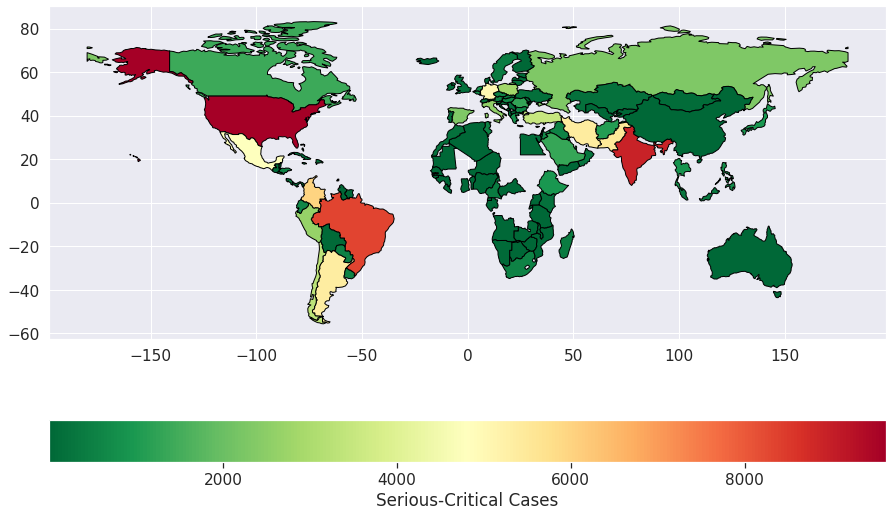

In [ ]:
merge.plot(column='Serious,Critical', figsize=(15,10), cmap='RdYlGn_r', label='Serious Critical Cases',edgecolor='black',  legend=True,legend_kwds={'label': "Serious-Critical Cases",'orientation': "horizontal"})


Worldwide Active Cases

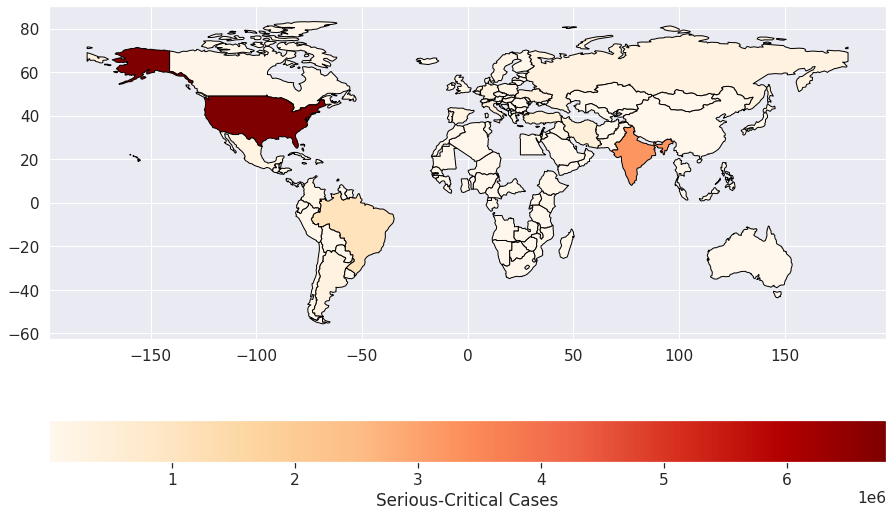

In [ ]:
merge.plot(column='ActiveCases', figsize=(15,10), cmap='OrRd', label='ActiveCases',edgecolor='black',  legend=True,legend_kwds={'label': "Serious-Critical Cases",'orientation': "horizontal"} )


Correlation Between 'TotalCases','Serious,Critical'

,TotalCases,"Serious,Critical"
TotalCases,1.000000,0.794570
"Serious,Critical",0.794570,1.000000


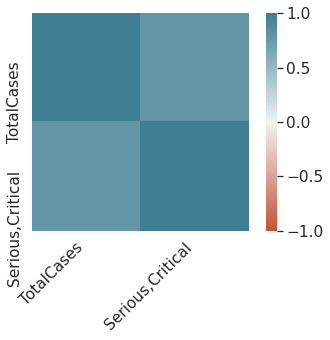

In [ ]:
import seaborn as sns
data_final_1 = data_final[['TotalCases','Serious,Critical']]
corr = data_final_1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


corr.style.background_gradient(cmap='coolwarm')


Serious Critical Cases by Continent Visualization

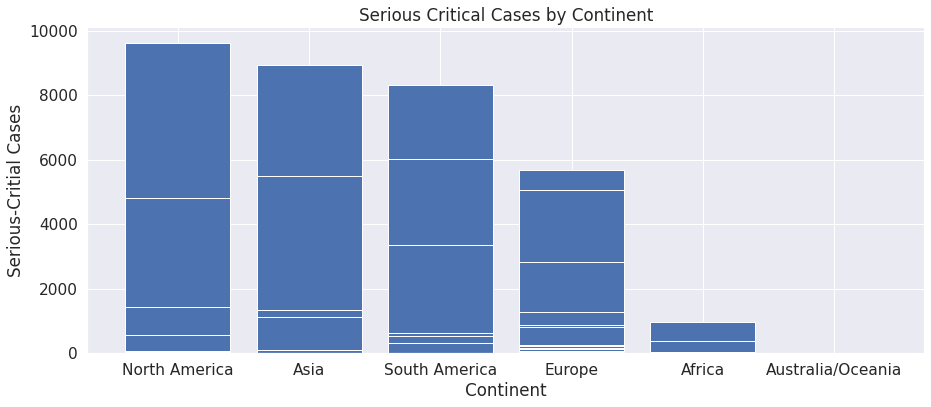

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar(NEW_data_updated['Continent'], NEW_data_updated['Serious,Critical'])
plt.title('Serious Critical Cases by Continent')
plt.xlabel('Continent')
plt.ylabel('Serious-Critial Cases')
plt.show()


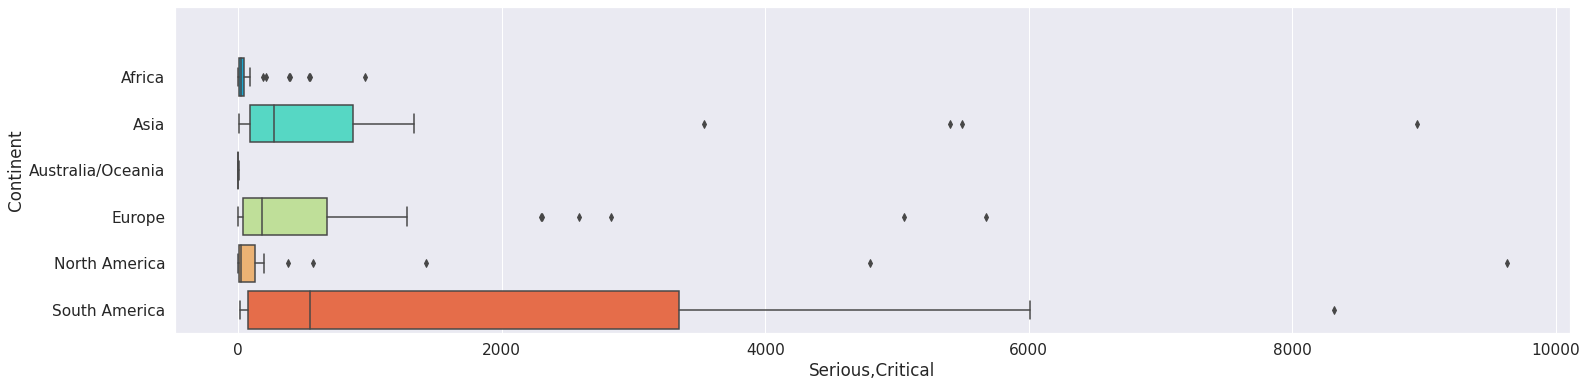

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 6))
sns.boxplot(x='Serious,Critical',y='Continent',data=NEW_data_updated,palette='rainbow')

In [ ]:
NEW_data_updated.head(5)

,Countries,TotalCases,ActiveCases,"Serious,Critical",Continent,Precautions,CODE
0,USA,33103974,6803777,9625,North America,high,USA
1,India,19164969,3268710,8944,Asia,high,IND
2,Brazil,14665962,1067137,8318,South America,high,BRA
3,France,5616689,972266,5675,Europe,medium,FRA
4,Turkey,4820591,456563,3534,Asia,medium,TUR


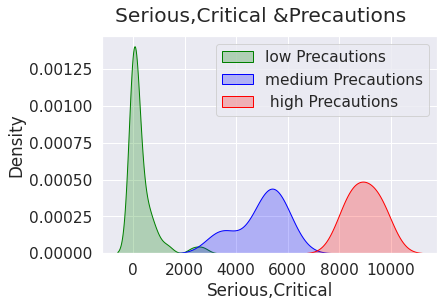

In [ ]:
#
fig, ax = plt.subplots()

sns.kdeplot(NEW_data_updated[NEW_data_updated["Precautions"]=="low"]["Serious,Critical"], shade=True, color="green", label="low Precautions", ax=ax)
sns.kdeplot(NEW_data_updated[NEW_data_updated["Precautions"]=="medium"]["Serious,Critical"], shade=True, color="blue", label="medium Precautions", ax=ax)
sns.kdeplot(NEW_data_updated[NEW_data_updated["Precautions"]=="high"]["Serious,Critical"], shade=True, color="red", label=" high Precautions", ax=ax)

ax.set_xlabel("Serious,Critical")
ax.set_ylabel("Density")

fig.suptitle("Serious,Critical &Precautions ");
ax.legend();

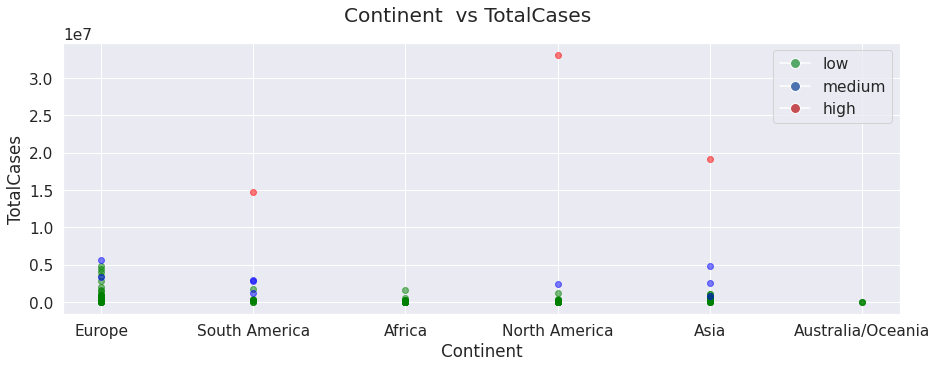

In [ ]:
from matplotlib.lines import Line2D

fig, ax =  plt.subplots(figsize=(15, 5))

ax.scatter(NEW_data_updated[NEW_data_updated["Precautions"]=="low"]["Continent"], NEW_data_updated[NEW_data_updated["Precautions"]=="low"]["TotalCases"], c="green", alpha=0.5)
ax.scatter(NEW_data_updated[NEW_data_updated["Precautions"]=="medium"]["Continent"], NEW_data_updated[NEW_data_updated["Precautions"]=="medium"]["TotalCases"], c="blue", alpha=0.5)
ax.scatter(NEW_data_updated[NEW_data_updated["Precautions"]=="high"]["Continent"], NEW_data_updated[NEW_data_updated["Precautions"]=="high"]["TotalCases"], c="red", alpha=0.5)
 

ax.set_xlabel("Continent")
ax.set_ylabel("TotalCases")

color_patches = [
    Line2D([0], [0], marker='o', color='w', label='low', markerfacecolor='g', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='medium', markerfacecolor='b', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='high', markerfacecolor='r', markersize=10)
]
ax.legend(handles=color_patches)


fig.suptitle("Continent  vs TotalCases");

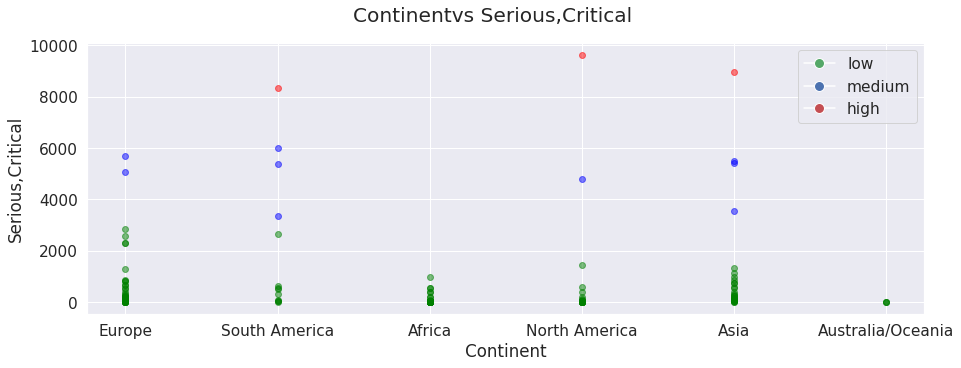

In [ ]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(NEW_data_updated[NEW_data_updated["Precautions"]=="low"]["Continent"], NEW_data_updated[NEW_data_updated["Precautions"]=="low"]["Serious,Critical"], c="green", alpha=0.5)
ax.scatter(NEW_data_updated[NEW_data_updated["Precautions"]=="medium"]["Continent"], NEW_data_updated[NEW_data_updated["Precautions"]=="medium"]["Serious,Critical"], c="blue", alpha=0.5)
ax.scatter(NEW_data_updated[NEW_data_updated["Precautions"]=="high"]["Continent"], NEW_data_updated[NEW_data_updated["Precautions"]=="high"]["Serious,Critical"], c="red", alpha=0.5)
 

ax.set_xlabel("Continent")
ax.set_ylabel("Serious,Critical")


color_patches = [
    Line2D([0], [0], marker='o', color='w', label='low', markerfacecolor='g', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='medium', markerfacecolor='b', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='high', markerfacecolor='r', markersize=10)
]
ax.legend(handles=color_patches)

fig.suptitle("Continentvs Serious,Critical");

Splitting into Train and Text datasets

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

X=NEW_data_updated[['Serious,Critical','TotalCases']]  # Features
y=NEW_data_updated['Precautions']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


#**Model Implementation**




Random Forest Model

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf  =RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=rf.predict(X_test)
rf = rf.fit(X_train,y_train)



Model Prediction

In [ ]:
# print results
y_pred=rf.predict(X_test)

In [ ]:
#Making probability Prediction
train_probs = rf.predict_proba(X_train)[:,1]
probs = rf.predict_proba(X_test)[:,1]
train_predictions = rf.predict(X_train)


X=NEW_data_updated[['Serious,Critical','TotalCases']]  # Features

FINAL_predictions = rf.predict(X)
NEW_data_updated['Predicted Precautions'] = FINAL_predictions
NEW_data_updated.head(10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Countries,TotalCases,ActiveCases,"Serious,Critical",Continent,Precautions,CODE,Predicted Precautions
0,USA,33103974,6803777,9625,North America,high,USA,high
1,India,19164969,3268710,8944,Asia,high,IND,high
2,Brazil,14665962,1067137,8318,South America,high,BRA,high
3,France,5616689,972266,5675,Europe,medium,FRA,medium
4,Turkey,4820591,456563,3534,Asia,medium,TUR,medium
5,Russia,4805288,267214,2300,Europe,low,RUS,low
6,UK,4416623,74315,196,Europe,low,GBR,low
7,Italy,4022653,436170,2583,Europe,low,ITA,low
8,Spain,3524077,239588,2308,Europe,low,ESP,low
9,Germany,3392232,313490,5049,Europe,medium,DEU,medium


#**Model Evaluation**




In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
#Accuracy (fraction of correctly classified samples)

accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")


The accuracy of the model is 97.8 %


#**Model Validation**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')


=== Confusion Matrix ===
[[ 1  0  0]
 [ 0 39  0]
 [ 0  1  4]]


=== Classification Report ===
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         1
         low       0.97      1.00      0.99        39
      medium       1.00      0.80      0.89         5

    accuracy                           0.98        45
   macro avg       0.99      0.93      0.96        45
weighted avg       0.98      0.98      0.98        45



